In [1]:
# Cell 1 — Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
import warnings
warnings.simplefilter("ignore", FutureWarning)

# File paths (adjust if needed)
COVID_CSV = Path("covid19_Confirmed_dataset.csv")
HAPPY_CSV = Path("worldwide_happiness_report.csv")

# Output paths
OUT_DIR = Path("/mnt/data")
OUT_DIR.mkdir(parents=True, exist_ok=True)
MERGED_CSV = OUT_DIR / "merged_covid_happiness.csv"
COUNTRY_TOTALS_CSV = OUT_DIR / "covid_country_totals.csv"
GLOBAL_TS_CSV = OUT_DIR / "covid_global_timeseries.csv"

print("Paths set. COVID:", COVID_CSV.exists(), "Happiness:", HAPPY_CSV.exists())


Paths set. COVID: True Happiness: True


In [2]:
# Load the CSVs
covid_raw = pd.read_csv(COVID_CSV)
happy_raw = pd.read_csv(HAPPY_CSV)

print("COVID shape:", covid_raw.shape)
print("Happiness shape:", happy_raw.shape)

# Quick head
display(covid_raw.head())
display(happy_raw.head())


COVID shape: (266, 104)
Happiness shape: (156, 9)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,609,634,663,678,712,726,736,750,766,773
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,717,723,723,731,738,738,743,743,743,745
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,24,25,25,25,25,26,27,27,27,27


,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


In [3]:
# Cell 4 — Identify date columns robustly
def is_date_like(colname: str) -> bool:
    s = str(colname)
    # require at least one digit and at least one slash or hyphen (common JHU format)
    if not any(ch.isdigit() for ch in s):
        return False
    if "/" not in s and "-" not in s:
        return False
    try:
        # try to parse
        pd.to_datetime([s], errors="raise", infer_datetime_format=True)
        return True
    except Exception:
        return False

covid_cols = covid_raw.columns.tolist()
date_cols = [c for c in covid_cols if is_date_like(c)]
# fallback: if not enough date columns, assume last 100 are dates (very unlikely)
if len(date_cols) < 5:
    date_cols = covid_cols[-100:]
print("Detected date columns count:", len(date_cols))
date_cols = sorted(date_cols, key=lambda x: pd.to_datetime(x, errors="coerce"))
date_cols[:5], date_cols[-5:]


Detected date columns count: 100


C:\Users\bhoum\AppData\Local\Temp\ipykernel_4492\1706387403.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime([s], errors="raise", infer_datetime_format=True)
C:\Users\bhoum\AppData\Local\Temp\ipykernel_4492\1706387403.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime([s], errors="raise", infer_datetime_format=True)
C:\Users\bhoum\AppData\Local\Temp\ipykernel_4492\1706387403.py:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the de

(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20'],
 ['4/26/20', '4/27/20', '4/28/20', '4/29/20', '4/30/20'])

In [4]:
# detect country column
country_candidates = ["Country/Region", "Country_Region", "Country", "country", "Country name"]
country_col = None
for cand in country_candidates:
    if cand in covid_raw.columns:
        country_col = cand
        break
if country_col is None:
    for c in covid_raw.columns:
        if "country" in c.lower():
            country_col = c
            break
if country_col is None:
    raise ValueError("Could not find a country column in COVID dataset.")

# Aggregate
covid_country = covid_raw.groupby(country_col)[date_cols].sum().reset_index()
latest_date = date_cols[-1]
covid_country['TotalConfirmed'] = covid_country[latest_date]
covid_country_totals = covid_country[[country_col, 'TotalConfirmed']].sort_values('TotalConfirmed', ascending=False).reset_index(drop=True)

print("Top 10 countries by total confirmed:")
display(covid_country_totals.head(10))


Top 10 countries by total confirmed:


,Country/Region,TotalConfirmed
0,US,1069424
1,Spain,213435
2,Italy,205463
3,United Kingdom,172481
4,France,167299
5,Germany,163009
6,Turkey,120204
7,Russia,106498
8,Iran,94640
9,Brazil,87187


In [5]:
# Build global time series (cumulative + daily new)
covid_global_ts = pd.DataFrame({
    "Date": pd.to_datetime(date_cols),
    "GlobalConfirmed": covid_country[date_cols].sum(axis=0).values
})
covid_global_ts = covid_global_ts.sort_values("Date").reset_index(drop=True)
covid_global_ts["GlobalNewCases"] = covid_global_ts["GlobalConfirmed"].diff().clip(lower=0).fillna(0)
display(covid_global_ts.head())


C:\Users\bhoum\AppData\Local\Temp\ipykernel_4492\1011596319.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  "Date": pd.to_datetime(date_cols),


,Date,GlobalConfirmed,GlobalNewCases
0,2020-01-22,555,0.0
1,2020-01-23,654,99.0
2,2020-01-24,941,287.0
3,2020-01-25,1434,493.0
4,2020-01-26,2118,684.0


In [6]:
def norm_country(s):
    if pd.isna(s):
        return s
    s = str(s).strip().lower()
    s = s.replace("&", "and")
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    # common mappings
    mapping = {
        "united states of america": "united states",
        "us": "united states",
        "u s": "united states",
        "uk": "united kingdom",
        "u k": "united kingdom",
        "korea, south": "south korea",
        "korea south": "south korea",
        "russian federation": "russian federation",
        "viet nam": "vietnam",
        "lao pdr": "laos",
        "bolivia (plurinational state of)": "bolivia",
        "iran (islamic republic of)": "iran",
        "brunei darussalam": "brunei",
        "cote d` ivoire": "cote d ivoire"
    }
    return mapping.get(s, s)

# apply to covid countries
covid_country['country_norm'] = covid_country[country_col].apply(norm_country)


In [7]:
# helper to find a likely column in a dataset by possible names
def find_col(df, candidates):
    for cand in candidates:
        for c in df.columns:
            if c.strip().lower() == cand.strip().lower():
                return c
    for cand in candidates:
        for c in df.columns:
            if cand.strip().lower() in c.strip().lower():
                return c
    return None

happy_country_col = find_col(happy_raw, ["Country", "Country name", "Country or region", "country"])
score_col = find_col(happy_raw, ["Happiness Score", "Score", "Ladder score", "Ladder Score"])
gdp_col = find_col(happy_raw, ["GDP per capita", "Logged GDP per capita", "GDP"])
health_col = find_col(happy_raw, ["Healthy life expectancy", "Health", "Life expectancy"])
support_col = find_col(happy_raw, ["Social support", "Support"])
freedom_col = find_col(happy_raw, ["Freedom to make life choices", "Freedom"])

print("Detected in happiness dataset -> country:", happy_country_col, "score:", score_col, "gdp:", gdp_col)


Detected in happiness dataset -> country: Country or region score: Score gdp: GDP per capita


In [8]:
keep_cols = [c for c in [happy_country_col, score_col, gdp_col, health_col, support_col, freedom_col] if c is not None]
happy_trim = happy_raw[keep_cols].copy()
# create normalized country key
happy_trim['country_norm'] = happy_trim[happy_country_col].apply(norm_country)
covid_merge_base = covid_country[['country_norm', 'TotalConfirmed']].copy()

merged = pd.merge(covid_merge_base, happy_trim, on='country_norm', how='inner')
# keep readable columns
readable = ['country_norm', 'TotalConfirmed']
if score_col: readable.append(score_col)
if gdp_col: readable.append(gdp_col)
if health_col: readable.append(health_col)
if support_col: readable.append(support_col)
if freedom_col: readable.append(freedom_col)
merged = merged[readable].copy()

# Add log scale to reduce skew
merged['LogTotalConfirmed'] = np.log1p(merged['TotalConfirmed'])

print("Merged shape:", merged.shape)
display(merged.head(10))


Merged shape: (147, 8)


,country_norm,TotalConfirmed,Score,GDP per capita,Healthy life expectancy,Social support,Freedom to make life choices,LogTotalConfirmed
0,afghanistan,2171,3.203,0.350,0.361,0.517,0.000,7.683404
1,albania,773,4.719,0.947,0.874,0.848,0.383,6.651572
2,algeria,4006,5.211,1.002,0.785,1.160,0.086,8.295798
3,argentina,4428,6.086,1.092,0.881,1.432,0.471,8.395929
4,armenia,2066,4.559,0.850,0.815,1.055,0.283,7.633854
5,australia,6766,7.228,1.372,1.036,1.548,0.557,8.819813
6,austria,15452,7.246,1.376,1.016,1.475,0.532,9.645558
7,azerbaijan,1804,5.208,1.043,0.769,1.147,0.351,7.498316
8,bahrain,3040,6.199,1.362,0.871,1.368,0.536,8.019942
9,bangladesh,7667,4.456,0.562,0.723,0.928,0.527,8.944811


In [9]:
#  Save prepared CSVs (for submission)
covid_country_totals.to_csv(COUNTRY_TOTALS_CSV, index=False)
covid_global_ts.to_csv(GLOBAL_TS_CSV, index=False)
merged.to_csv(MERGED_CSV, index=False)
print("Saved files:")
print("-", COUNTRY_TOTALS_CSV)
print("-", GLOBAL_TS_CSV)
print("-", MERGED_CSV)


Saved files:
- \mnt\data\covid_country_totals.csv
- \mnt\data\covid_global_timeseries.csv
- \mnt\data\merged_covid_happiness.csv


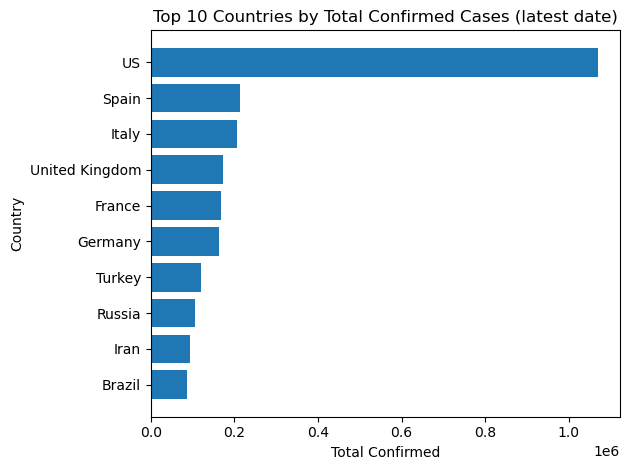

In [10]:
# (A) Top 10 countries by total confirmed
top10 = covid_country_totals.head(10)
plt.figure()
plt.barh(top10[country_col].astype(str).iloc[::-1], top10['TotalConfirmed'].iloc[::-1])
plt.title("Top 10 Countries by Total Confirmed Cases (latest date)")
plt.xlabel("Total Confirmed")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


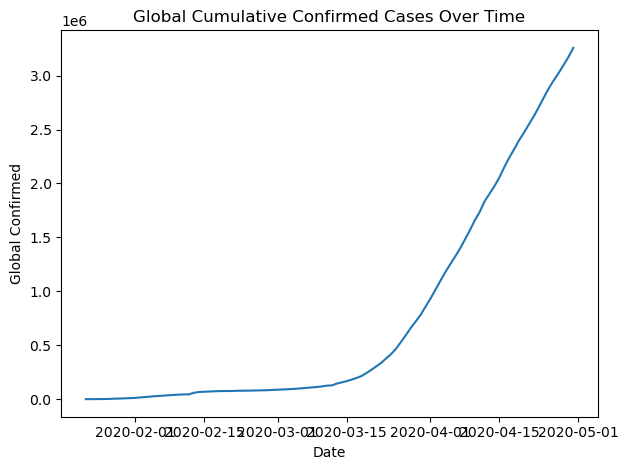

In [11]:
# (B) Global cumulative cases over time
plt.figure()
plt.plot(covid_global_ts['Date'], covid_global_ts['GlobalConfirmed'])
plt.title("Global Cumulative Confirmed Cases Over Time")
plt.xlabel("Date")
plt.ylabel("Global Confirmed")
plt.tight_layout()
plt.show()


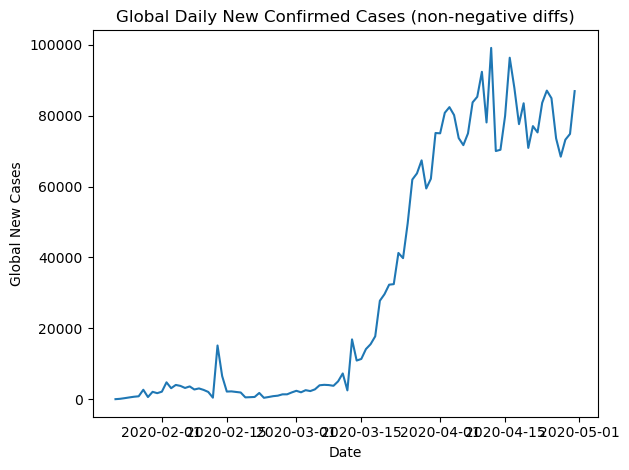

In [12]:
# (C) Daily new global cases (timeseries)
plt.figure()
plt.plot(covid_global_ts['Date'], covid_global_ts['GlobalNewCases'])
plt.title("Global Daily New Confirmed Cases (non-negative diffs)")
plt.xlabel("Date")
plt.ylabel("Global New Cases")
plt.tight_layout()
plt.show()


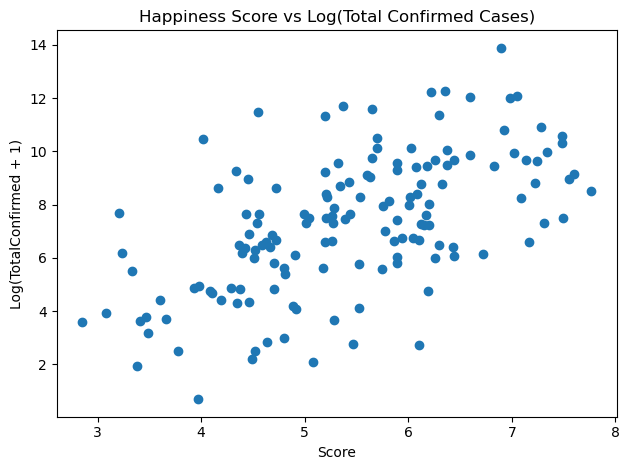

In [13]:
# (D) Scatter: Happiness Score vs Log(Total Cases) if score exists
if score_col and score_col in merged.columns:
    plt.figure()
    plt.scatter(merged[score_col], merged['LogTotalConfirmed'])
    plt.title("Happiness Score vs Log(Total Confirmed Cases)")
    plt.xlabel(score_col)
    plt.ylabel("Log(TotalConfirmed + 1)")
    plt.tight_layout()
    plt.show()
else:
    print("Happiness score column not found — skipping scatter.")


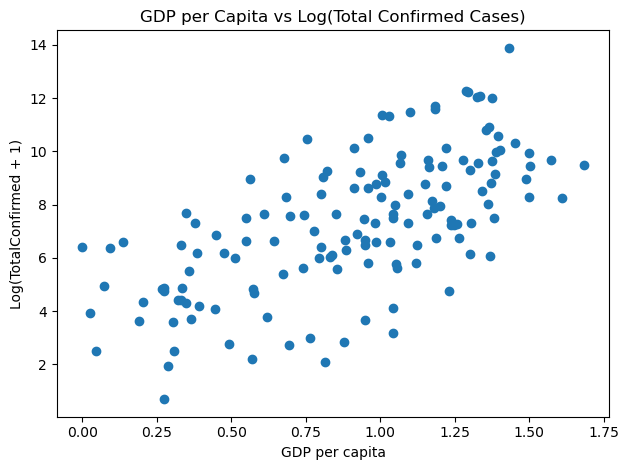

In [14]:
# (E) Scatter: GDP per capita vs Log(Total Cases) if GDP column exists
if gdp_col and gdp_col in merged.columns:
    plt.figure()
    plt.scatter(merged[gdp_col], merged['LogTotalConfirmed'])
    plt.title("GDP per Capita vs Log(Total Confirmed Cases)")
    plt.xlabel(gdp_col)
    plt.ylabel("Log(TotalConfirmed + 1)")
    plt.tight_layout()
    plt.show()
else:
    print("GDP column not found — skipping GDP scatter.")


In [15]:
# compute Pearson correlations between LogTotalConfirmed and numeric happiness indicators
numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
targets = [c for c in numeric_cols if c != 'TotalConfirmed']  # we use LogTotalConfirmed
corr_df = merged[['LogTotalConfirmed'] + [c for c in targets if c != 'LogTotalConfirmed']].corr(method='pearson')
display(corr_df)

# Print top 5 absolute correlations with LogTotalConfirmed
if 'LogTotalConfirmed' in corr_df.columns:
    corrs = corr_df['LogTotalConfirmed'].drop('LogTotalConfirmed', errors='ignore').abs().sort_values(ascending=False)
    print("Top correlations with LogTotalConfirmed:")
    print(corrs.head(5))
else:
    print("No numeric correlations computed.")


,LogTotalConfirmed,Score,GDP per capita,Healthy life expectancy,Social support,Freedom to make life choices
LogTotalConfirmed,1.000000,0.584983,0.647916,0.605874,0.463358,0.267277
Score,0.584983,1.000000,0.798095,0.797514,0.790853,0.574326
GDP per capita,0.647916,0.798095,1.000000,0.861267,0.760473,0.377883
Healthy life expectancy,0.605874,0.797514,0.861267,1.000000,0.760129,0.404240
Social support,0.463358,0.790853,0.760473,0.760129,1.000000,0.452354
Freedom to make life choices,0.267277,0.574326,0.377883,0.404240,0.452354,1.000000


Top correlations with LogTotalConfirmed:
GDP per capita                  0.647916
Healthy life expectancy         0.605874
Score                           0.584983
Social support                  0.463358
Freedom to make life choices    0.267277
Name: LogTotalConfirmed, dtype: float64


In [16]:
# Print a compact report of the main results
print("=== Compact Summary ===")
print("Top 5 countries by Total Confirmed:")
display(top10.head(5))
print("\nGlobal cumulative last date:", covid_global_ts['Date'].max())
print("Global confirmed on last date:", int(covid_global_ts['GlobalConfirmed'].max()))
print("\nMerged dataset rows (countries matched):", merged.shape[0])
if 'LogTotalConfirmed' in merged.columns and score_col and score_col in merged.columns:
    # show sample rows with highest cases
    display(merged.sort_values('TotalConfirmed', ascending=False).head(10)[['country_norm', score_col, 'TotalConfirmed', 'LogTotalConfirmed']])


=== Compact Summary ===
Top 5 countries by Total Confirmed:


,Country/Region,TotalConfirmed
0,US,1069424
1,Spain,213435
2,Italy,205463
3,United Kingdom,172481
4,France,167299



Global cumulative last date: 2020-04-30 00:00:00
Global confirmed on last date: 3256846

Merged dataset rows (countries matched): 147


,country_norm,Score,TotalConfirmed,LogTotalConfirmed
135,united states,6.892,1069424,13.882632
122,spain,6.354,213435,12.271092
62,italy,6.223,205463,12.233026
139,united kingdom,7.054,172481,12.058048
43,france,6.592,167299,12.027544
47,germany,6.985,163009,12.001567
134,turkey,5.373,120204,11.696954
110,russia,5.648,106498,11.575891
58,iran,4.548,94640,11.457846
17,brazil,6.300,87187,11.375822
